# Objective:

The purpose of this notebook is to implement a pipeline for feature selection, considering the assumption of multicollinearity among variables. Next, we will explore non-linear models on our dataset, apply Optuna for hyperparameter tuning, and ultimately select the best-performing model.


# Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
pd.options.display.float_format = '{:.9f}'.format
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
from typing import List, Dict
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence


from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, ParameterGrid
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, \
                                  FunctionTransformer, PowerTransformer, RobustScaler, MaxAbsScaler,  KBinsDiscretizer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest, f_regression, chi2
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import optuna
import joblib
import optuna.visualization as vis
#Reusable packages
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))
from Functions.feature_selection import *


c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2025) #always the same for every time we call cv
df_train = pd.read_csv('..//data//preprocessed_data//train_processed.csv')
df_train = df_train.iloc[:,1:]
X_train = df_train.drop(['SalePrice'], axis = 1)
y_train = df_train['SalePrice']
df_test = pd.read_csv('..//data//preprocessed_data//test_processed.csv')
df_test = df_test.iloc[:, 1:]
#df_test.head()

# Baseline Model

Now that we have all our data preprocessed, we can run a model with all variables as a starting point. This will help us to know if we change something how this impacts the final score. We will validate the baseline score using a cv=5 approach.

The mean squared error with 5 cv is: 0.013009


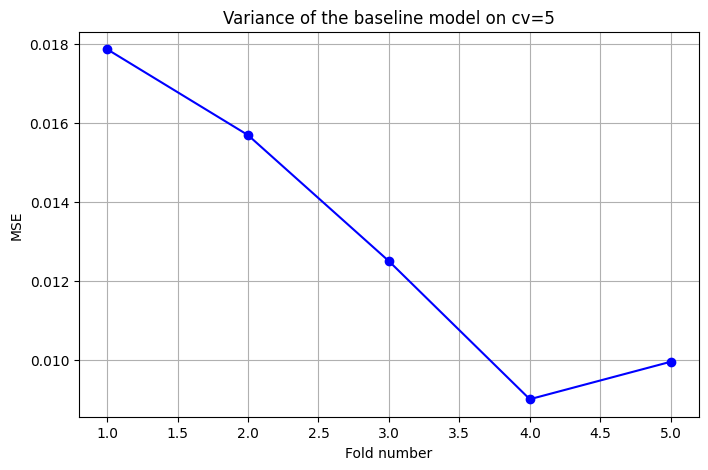

In [3]:
baseline = LinearRegression()
mse_scores = cross_val_score(baseline, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kfold, n_jobs=-1)
mse = abs(np.mean(mse_scores))
print(f'The mean squared error with 5 cv is: {mse:.6f}')

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), abs(mse_scores), marker='o', linestyle='-', color='b')
plt.xlabel('Fold number')
plt.ylabel('MSE')
plt.title('Variance of the baseline model on cv=5')
plt.grid(True)
plt.show()

# Feature Selection

Firstly we are going to create some filters in order to identify which variables are the most important. We want to achieve the combination of variables that minimices the MSE and posseses the lowest variance possible.

This filter will only be use for models affected by high dimmensions or multicollineality (Linear models or Distance Based models). Other models like ensemblers can handle this problem. The process of feature selection will be the following:

1. High-Collinearity Filter: We identify and remove independent variables that exhibit high correlation with others.The approach involves comparing pairs of correlated variables and dropping the one with the lower impact on the target variable.

2. L1 Regularization Filter (Lasso):After the first filter, we standardize the dataset and apply Lasso regression. Using GridSearch, we determine the optimal alpha value that minimizes MSE. Features with the least impact on the model are eliminated.

3. Forward & Backward Selection: Once irrelevant variables are removed, we apply sequential feature selection, using the following steps:

    *    Forward Selection: Iteratively adds features that improve model
    *    3.2. Backward Selection: Iteratively removes features that degrade model performance the least.
    *   3.3. The final feature subset is obtained by taking the intersection of both selections.
    *   3.4. We then reapply the approach and choose the configuration that provides the lowest MSE, considering the degrees of freedom of the final model.





In [4]:
#Binary variables dont require any transformation
binary_columns = []
for col in X_train.columns:
    if X_train[col].nunique() <= 2:
        binary_columns.append(col)

apply_scaler = list(set(X_train.columns) - set(binary_columns))
print(f'Variables which are going to be scaled: {apply_scaler}')
print(f'Binary variables: {binary_columns}')

Variables which are going to be scaled: ['Condition2', 'Total_Close_Live_Area', 'Avg_Quality', 'MSZoning', 'Exterior2nd', 'BsmtFullBath', 'BsmtQual', 'House_Age', 'SaleType_Neighbord', 'Remodeled_Ratio', 'Electrical', 'Neighborhood', 'Log_MiscVal', 'HeatingQC', 'Quality_conditition', 'FireplaceQu', 'MiscFeature', 'YearBuilt', 'Exterior_Score', 'SaleType', 'PavedDrive', 'Log_LotArea_binned', 'Exterior1st', 'Log_Bathroom_Density', 'Luxury_Index_Avg', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'House_Count', 'YearRemodAdd', 'Log_LowQualFinSF', 'BldgType', 'BedroomAbvGr', 'LandSlope', 'PoolQC', 'RoofStyle', 'HouseStyle', 'Foundation', 'GarageQual', 'OverallCond', 'Log_Living_Space_Ratio', 'Log_MasVnrArea_binned', 'Price_per_sqm', 'BsmtFinType2', 'Number_of_floors', 'GarageYrBlt', 'BsmtUnfSF', 'TotRmsAbvGrd', '2ndFlrSF_binned', 'GarageType', 'MasVnrType', 'YrSold', 'House_Age2', 'SaleCondition', 'Log_Lot_occupation', 'Alley', 'Log_BsmtFinSF2', 'Log_LotArea', 'FullBath', 'Log_WoodDeckSF', 'Bsm

# Rescaling the variables
During the preprocessing stage, we applied different scalers to various features. However, since we now want to apply L1 regularization, it is crucial to ensure that all features are on the same scale.

L1 regularization acts as a filter by penalizing feature coefficients, meaning that differences in scale can significantly impact the selection process. To ensure an effective regularization, we will standardize all variables before proceeding.

In [5]:
class ScalerTransf(BaseEstimator, TransformerMixin):
    def __init__(self, columns, type_scaler='StandardScaler'):
        self.columns = columns
        self.type_scaler = type_scaler
        self.scaler = None

    def fit(self, X, y=None):
        if self.type_scaler == 'StandardScaler':
            self.scaler = StandardScaler()
        elif self.type_scaler == 'MinMaxScaler':
            self.scaler = MinMaxScaler()
        elif self.type_scaler == 'RobustScaler':
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"Scaler '{self.type_scaler}' not valid, use: 'StandardScaler', 'MinMaxScaler' o 'RobustScaler'.")

        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_transf = X.copy()
        X_transf[self.columns] = self.scaler.transform(X_transf[self.columns])
        return X_transf

pipeline = Pipeline(steps=[
    ('Applying_scaler', ScalerTransf(columns=apply_scaler)),
    ('LinearModel', LinearRegression())
])
param_grid = {
    'Applying_scaler__type_scaler': ['StandardScaler']
}

grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)
best_scaler = grid.best_params_['Applying_scaler__type_scaler']
print(f'Best Scaler: {best_scaler}')
print(f'Lowest MSE: {-grid.best_score_:.6f}')
best_pipeline = grid.best_estimator_


X_train_scaled = best_pipeline[:-1].transform(X_train)
X_test_scaled = best_pipeline[:-1].transform(df_test)

Best Scaler: StandardScaler
Lowest MSE: 0.012897


c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\javie\OneDrive\Escritorio\HousePrediction\HousingPrediction\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# Filter based on high colineality:

In [6]:
class VariableSelector(BaseEstimator, TransformerMixin):
    def __init__(self, mi_threshold=0.01, corr_threshold=0.01, max_corr_threshold=0.9, flag=True):
        self.mi_threshold = mi_threshold
        self.corr_threshold = corr_threshold
        self.max_corr_threshold = max_corr_threshold
        self.flag = flag
        self.selected_vars_ = None

    def fit(self, X, y=None):
        if not self.flag:
            self.selected_vars_ = X.columns  #If grid says better not to filter Flags = False
            return self

        if isinstance(y, pd.Series):
            y = y.to_frame()

        combined_df = pd.concat([X, y], axis=1)
        target_col = y.columns[0]
        corr_with_target = combined_df.corr()[target_col].abs().drop(target_col).sort_values(ascending=False)

        mi_with_target = mutual_info_regression(X, y.squeeze())
        mi_with_target = pd.Series(mi_with_target, index=X.columns)
        mi_with_target = mi_with_target.reindex(corr_with_target.index)

        mask = (corr_with_target >= self.corr_threshold) | (mi_with_target >= self.mi_threshold)
        filtered_vars = corr_with_target.index[mask]

        corr_matrix = X[filtered_vars].corr().abs()
        selected_vars = []
        for var in filtered_vars:
            if not any(corr_matrix.loc[var, sv] > self.max_corr_threshold for sv in selected_vars):
                selected_vars.append(var)

        self.selected_vars_ = selected_vars
        return self

    def transform(self, X):
        return X[self.selected_vars_]


pipeline_colineality_filter = Pipeline(steps=[
    ('Eliminating_Colineality', VariableSelector()),
    ('LinearModel', LinearRegression())
])

param_grid = {'Eliminating_Colineality__flag': [True, False]}

grid = GridSearchCV(pipeline_colineality_filter, param_grid, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_filter = grid.best_params_['Eliminating_Colineality__flag']
print(f'Best Filter Flag: {best_filter}')
print(f'Lowest MSE: {-grid.best_score_:.6f}')

best_pipeline = grid.best_estimator_


X_train_scaled = best_pipeline[:-1].transform(X_train_scaled) #Dont apply the last step of pipeline
X_test_scaled = best_pipeline[:-1].transform(X_test_scaled)

print(f'Now the shape of train is: {X_train_scaled.shape}, before it was: {X_train.shape}')

Best Filter Flag: True
Lowest MSE: 0.012803
Now the shape of train is: (1454, 110), before it was: (1454, 139)


# Lasso Filter

In [7]:
class L1Filter(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.01, flag=True):
        self.alpha = alpha
        self.flag = flag
        self.selected_vars_ = None
        self.lasso_cv = None

    def fit(self, X, y):
        if not self.flag:
            self.selected_vars_ = X.columns
            return self

        self.lasso_cv = Lasso(alpha=self.alpha).fit(X, y)
        selected = self.lasso_cv.coef_ != 0
        self.selected_vars_ = X.columns[selected]


        if len(self.selected_vars_) == 0: #IF alpha tend to infinity
            self.selected_vars_ = X.columns
            warnings.warn("No features selected by Lasso. Using all features instead.", UserWarning)
        return self

    def transform(self, X):
        return X[self.selected_vars_]

pipeline_l1filter = Pipeline(steps=[
    ('L1_filter', L1Filter()),
    ('LinearModel', LinearRegression())
])

param_grid = {
    'L1_filter__alpha': np.logspace(-5, 2, 500),
    'L1_filter__flag': [True, False]
}

grid = GridSearchCV(pipeline_l1filter, param_grid, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1)
grid.fit(X_train_scaled, y_train)


best_alpha = grid.best_params_['L1_filter__alpha']
best_flag = grid.best_params_['L1_filter__flag']
print(f'Best Filter Alpha: {best_alpha}')
print(f'Best Filter Flag: {best_flag}')
print(f'Lowest MSE: {-grid.best_score_:.6f}')

best_pipeline = grid.best_estimator_

X_train_lasso = best_pipeline[:-1].transform(X_train_scaled)
X_test_lasso = best_pipeline[:-1].transform(X_test_scaled)

print(f'Shape after Lasso (train): {X_train_lasso.shape}, before: {X_train_scaled.shape}')
print(f'Shape after Lasso (test): {X_test_lasso.shape}, before: {X_test_scaled.shape}')


Best Filter Alpha: 0.0005488819609789672
Best Filter Flag: True
Lowest MSE: 0.012666
Shape after Lasso (train): (1454, 90), before: (1454, 110)
Shape after Lasso (test): (1459, 90), before: (1459, 110)


# Sequential Feature Selection Filter

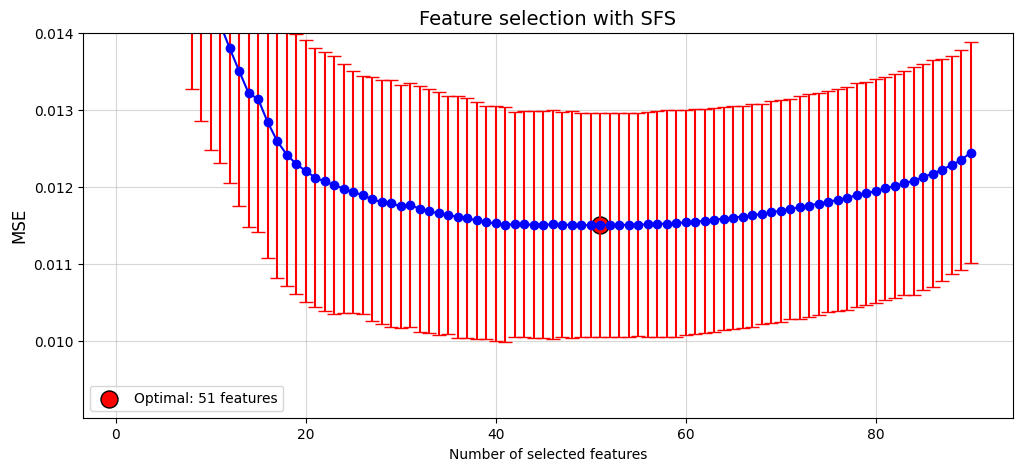

In [8]:
results, sfs_backward = sfs(LinearRegression(), X_train_lasso, y_train, k_f = 'best', method_selection = False)

In [9]:
vars_backward = get_selected_vars(sfs_backward)

The number of variables selected was: 51
0 - Log_Area_Quality_Indicator
1 - Total_Close_Live_Area
2 - SaleCondition_Neighbord
3 - Insulation_Quality
4 - Luxury_Index
5 - GarageCars
6 - Luxury_Index_Avg
7 - KitchenQual
8 - 1stFlrSF
9 - Price_per_sqm
10 - GarageFinish
11 - Avg_Room_Size
12 - Years_Since_Remodel
13 - Foundation
14 - FireplaceQu
15 - TotRmsAbvGrd
16 - Thermal_Efficiency
17 - Log_Bathroom_Density_binned
18 - Fireplaces
19 - Count_Attributes
20 - GarageType
21 - Exterior1st
22 - MSZoning
23 - Log_LotArea
24 - Age_Variation_binned
25 - SaleType_SaleCondition
26 - GarageQual
27 - BsmtExposure
28 - CentralAir_Y
29 - Log_WoodDeckSF
30 - HouseStyle
31 - LotFrontage_binned
32 - HalfBath
33 - Paved_Area_Ratio
34 - Electrical
35 - Remodeled_Ratio
36 - BsmtUnfSF
37 - Condition1
38 - Number_of_floors
39 - LotFrontage
40 - Frontage_Ratio
41 - LotConfig
42 - KitchenAbvGr
43 - Functional
44 - RoofMatl
45 - Log_ScreenPorch
46 - PoolQC
47 - Log_LowQualFinSF
48 - OverallCond
49 - Log_BsmtFi

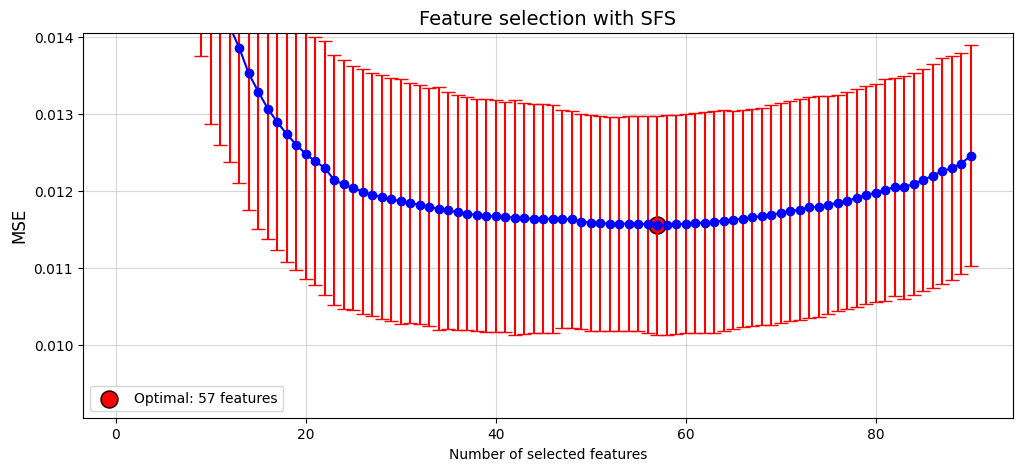

The number of variables selected was: 57
0 - Log_Area_Quality_Indicator
1 - Total_Close_Live_Area
2 - SaleCondition_Neighbord
3 - Insulation_Quality
4 - GrLivArea
5 - Luxury_Index
6 - GarageCars
7 - ExterQual
8 - Luxury_Index_Avg
9 - TotalBath
10 - GarageArea
11 - KitchenQual
12 - 1stFlrSF
13 - Price_per_sqm
14 - GarageFinish
15 - Years_Since_Remodel
16 - Foundation
17 - FireplaceQu
18 - Thermal_Efficiency
19 - Log_Bathroom_Density_binned
20 - Fireplaces
21 - GarageType
22 - Exterior1st
23 - MSZoning
24 - Log_LotArea
25 - Age_Variation_binned
26 - SaleType_SaleCondition
27 - Log_Outside_live_area
28 - GarageQual
29 - BsmtExposure
30 - CentralAir_Y
31 - Log_WoodDeckSF
32 - BsmtFinType1
33 - HouseStyle
34 - LotFrontage_binned
35 - HalfBath
36 - Paved_Area_Ratio
37 - Electrical
38 - BsmtCond
39 - Remodeled_Ratio
40 - BsmtUnfSF
41 - Condition1
42 - Number_of_floors
43 - LotFrontage
44 - Frontage_Ratio
45 - LotConfig
46 - KitchenAbvGr
47 - Functional
48 - RoofMatl
49 - Log_ScreenPorch
50 - 

In [10]:
results, sfs_forward = sfs(LinearRegression(), X_train_lasso, y_train, k_f = 'best', method_selection=True)
vars_forward = get_selected_vars(sfs_forward)

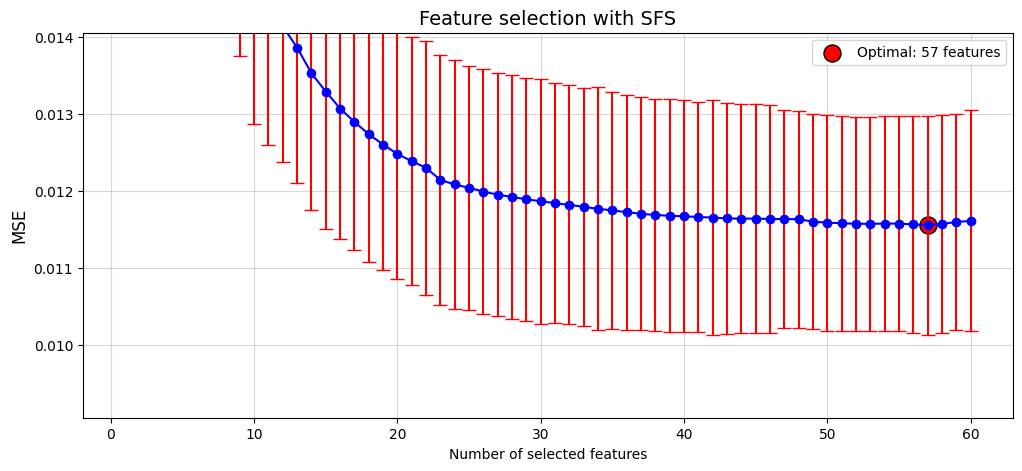

The number of variables selected was: 57
0 - Total_Close_Live_Area
1 - MSZoning
2 - Log_BsmtFinSF2
3 - Log_LotArea
4 - Log_WoodDeckSF
5 - Is_Remodeled_1
6 - Log_Livability_Ratio
7 - SaleCondition_Neighbord
8 - Electrical
9 - Remodeled_Ratio
10 - Age_Variation_binned
11 - BsmtExposure
12 - LotFrontage
13 - GarageArea
14 - Luxury_Index
15 - FireplaceQu
16 - LotConfig
17 - Years_Since_Remodel
18 - GrLivArea
19 - KitchenQual
20 - Log_ScreenPorch
21 - SaleType_SaleCondition
22 - TotalBath
23 - Exterior1st
24 - Luxury_Index_Avg
25 - GarageCars
26 - 1stFlrSF
27 - Functional
28 - ExterQual
29 - Log_Area_Quality_Indicator
30 - HalfBath
31 - Insulation_Quality
32 - Log_LowQualFinSF
33 - PoolQC
34 - Fireplaces
35 - BsmtFinType1
36 - BsmtCond
37 - HouseStyle
38 - Foundation
39 - GarageQual
40 - CentralAir_Y
41 - KitchenAbvGr
42 - OverallCond
43 - RoofMatl
44 - Price_per_sqm
45 - Frontage_Ratio
46 - BsmtFinType2
47 - Log_Bathroom_Density_binned
48 - LotFrontage_binned
49 - Condition1
50 - Number_of

In [11]:
#Forward method with both vars selected by both filters
vars_selected = list(set(vars_forward) | set(vars_backward))
results, sfs_forward_filtered = sfs(LinearRegression(), X_train_lasso[vars_selected], y_train,k_f = 'best', method_selection=True)
vars_forward_filter = get_selected_vars(sfs_forward_filtered)


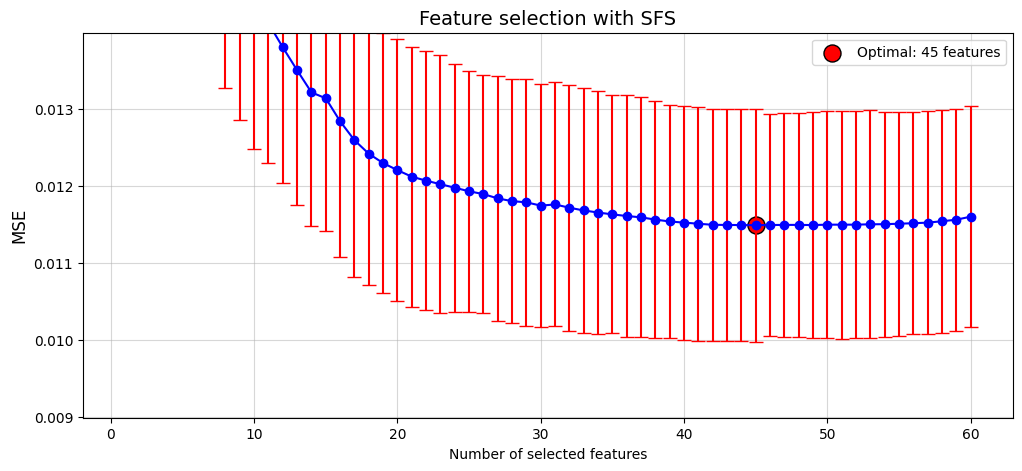

The number of variables of the backward approach was: 45
The score of backward was: -0.011495209655219652
The number of variables of the forward approach was: 57
The score of forward was: -0.011549984733821468


In [12]:
results, sfs_backward_filtered = sfs(LinearRegression(), X_train_lasso[vars_selected], y_train, k_f = 'best', method_selection=False)

vars_backward_filter = get_selected_vars(sfs_backward_filtered, info = False)
print(f'The number of variables of the backward approach was: {len(vars_backward_filter)}')
print(f'The score of backward was: {sfs_backward_filtered.k_score_}')

print(f'The number of variables of the forward approach was: {len(vars_forward_filter)}')
print(f'The score of forward was: {sfs_forward_filtered.k_score_}')


# Data Filtered

In [13]:
X_train_filtered = X_train_lasso[vars_backward_filter].copy()
X_train_filtered.loc[:, 'SalePrice']  = y_train
X_test_filtered = X_test_lasso[vars_backward_filter]
X_train_filtered.to_csv('..//data//filtered_data//train_filtered.csv')
X_test_filtered.to_csv('..//data//filtered_data//test_filtered.csv')
print(f'Final selection: {X_train_filtered.columns}')

Final selection: Index(['Total_Close_Live_Area', 'MSZoning', 'Log_BsmtFinSF2', 'Log_LotArea',
       'Log_WoodDeckSF', 'Log_Livability_Ratio', 'SaleCondition_Neighbord',
       'Count_Attributes', 'Electrical', 'Remodeled_Ratio', 'BsmtExposure',
       'LotFrontage', 'Luxury_Index', 'FireplaceQu', 'LotConfig',
       'Years_Since_Remodel', 'KitchenQual', 'Log_ScreenPorch',
       'SaleType_SaleCondition', 'Exterior1st', 'GarageCars', '1stFlrSF',
       'Functional', 'Log_Area_Quality_Indicator', 'Insulation_Quality',
       'Log_LowQualFinSF', 'PoolQC', 'Fireplaces', 'GarageQual',
       'CentralAir_Y', 'KitchenAbvGr', 'OverallCond', 'RoofMatl',
       'Price_per_sqm', 'Frontage_Ratio', 'Log_Bathroom_Density_binned',
       'Avg_Room_Size', 'LotFrontage_binned', 'Condition1', 'Number_of_floors',
       'Thermal_Efficiency', 'Paved_Area_Ratio', 'TotRmsAbvGrd', 'BsmtUnfSF',
       'Log_Outside_live_area', 'SalePrice'],
      dtype='object')


# SVR

The SVR model is based on distances, and in the previous notebook, we observed that most of our data follows distributions that are close to normal. This suggests that SVR could perform really well on this dataset.

The objective of tunning this model is to find the optimal C parameter, which can be understood as a "budget" for errors. Specifically, C controls the trade-off between achieving a low error on the training data and maintaining a smooth decision boundary. A larger C applies less regularization, allowing the model to fit the data more closely, while a smaller C increases regularization, making the model more robust to outliers by allowing more margin for errors.

For the tunning I'll be using optuna in order to use a faster hypertunning approach.



In [14]:
#Checkpoints in order to avoid rerunning previous cells
X_train_prepared = pd.read_csv('..//data//filtered_data//train_filtered.csv')
X_test_prepared = pd.read_csv('..//data//filtered_data//test_filtered.csv')
X_train_prepared = X_train_prepared.iloc[:, 1:]
X_train = X_train_prepared.drop(['SalePrice'], axis = 1)
y_train = X_train_prepared['SalePrice']
vars_selected = X_train.columns

X_train = X_train_prepared[vars_selected]
X_test_prepared = X_test_prepared.iloc[:, 1:]
#X_train.info()

In [15]:
#Baseline SVR
svr = SVR(kernel='linear')
mse = cross_val_mse_score(svr, X_train, y_train, info = True)

The MSE obtained was: 0.011580310106864602
The std obtained was: 0.0033522701928401224


In [16]:
def objective_svr(trial):
    budget = trial.suggest_float('C', 0.0001, 1)
    #kernel_ = trial.suggest_categorical('kernel', ['linear']) #Discarted all the other types of kernel on a previous iteration
    #eps = trial.suggest_float('epsilon', 0.001, 1, log = True) #Base epsilon is good enough
    svr = SVR(kernel='linear', C=budget)
    mse = cross_val_mse_score(svr, X_train, y_train)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective_svr, n_trials=1000)
best_C =  study.best_params['C']
print(f'Mejor C encontrado: {best_C}')

best_svr = SVR(kernel = 'linear', C = best_C).fit(X_train, y_train)
joblib.dump(best_svr, '..//data//models_trained//best_svr.pkl')
print('model saved!')






[I 2025-02-28 22:43:18,335] A new study created in memory with name: no-name-7ea8da47-48f4-4940-b6c2-c06d4a5066c2
[I 2025-02-28 22:43:18,968] Trial 0 finished with value: 0.011580572585086001 and parameters: {'C': 0.7996164659635762}. Best is trial 0 with value: 0.011580572585086001.
[I 2025-02-28 22:43:19,752] Trial 1 finished with value: 0.011575146314939048 and parameters: {'C': 0.9918405445494358}. Best is trial 1 with value: 0.011575146314939048.
[I 2025-02-28 22:43:20,367] Trial 2 finished with value: 0.011578061267856932 and parameters: {'C': 0.7096676658319567}. Best is trial 1 with value: 0.011575146314939048.
[I 2025-02-28 22:43:21,017] Trial 3 finished with value: 0.01158352588175341 and parameters: {'C': 0.8666940925043597}. Best is trial 1 with value: 0.011575146314939048.
[I 2025-02-28 22:43:21,683] Trial 4 finished with value: 0.011587124006338934 and parameters: {'C': 0.8833032754933946}. Best is trial 1 with value: 0.011575146314939048.
[I 2025-02-28 22:43:22,425] Tria

Mejor C encontrado: 0.01775324656902829
model saved!


# KNN

This is another distance based model where instances are classified based on their similarity to their neighbords. The main hyperparameter is the number of neighbords to be accountted to positionate our observations. We also tunned weights which determine how mcuh each neighbord contributes to the models impact and metric which quantifies the distance in the feature space

In [17]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 128)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    mse = cross_val_mse_score(knn, X_train, y_train)
    

    return mse

# Crear y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective_knn, n_trials=1000)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print(f"Mejores hiperparámetros encontrados: {best_params}")

best_knn = KNeighborsRegressor(**best_params).fit(X_train, y_train)
joblib.dump(best_knn, '..//data//models_trained//best_knn.pkl')
print('model saved!')






[I 2025-02-28 22:45:37,589] A new study created in memory with name: no-name-12e88f06-3d19-4daa-8026-4a7aaa86899a
[I 2025-02-28 22:45:37,756] Trial 0 finished with value: 0.037290242528031856 and parameters: {'n_neighbors': 118, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.037290242528031856.
[I 2025-02-28 22:45:37,909] Trial 1 finished with value: 0.029317638919575444 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.029317638919575444.
[I 2025-02-28 22:45:38,105] Trial 2 finished with value: 0.030180953885089602 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.029317638919575444.
[I 2025-02-28 22:45:38,206] Trial 3 finished with value: 0.031835177661422145 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.029317638919575444.
[I 2025-02-28 22:45:38,245] Trial 4 finishe

Mejores hiperparámetros encontrados: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}
model saved!


# Penalty Regressions

These models are regular linear regressions that incorporate a hyperparameter, alpha, to regulate the impact of variable coefficients within the loss function. When a variable lacks predictive power, increasing alpha determines the degree of penalty imposed.

Ridge regression employs an L2 penalty, which effectively shrinks the coefficients of low-contributing predictors towards zero. This regularization technique helps prevent overfitting by reducing the model's sensitivity to minor fluctuations in the data.

On the other hand, Lasso regression utilizes an L1 penalty, which not only shrinks coefficients but can also force some coefficients to exactly zero. This characteristic makes Lasso particularly useful for feature selection, as it identifies and excludes unnecessary variables from the model.

The alpha parameter in both Ridge and Lasso regressions dictates the strength of regularization applied to penalize poorly performing predictors. Higher alpha values increase the penalty, leading to more pronounced coefficient shrinkage or sparsity in the model.

# Ridge

In [18]:
def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 1e-6, 1e2)
    model = Ridge(alpha=alpha)

    mse = cross_val_mse_score(model, X_train, y_train)
    return mse


study_1 = optuna.create_study(direction='minimize')
study_1.optimize(objective_ridge, n_trials=1500)
best_alpha = study_1.best_params['alpha']
print(f'Best alpha obtained on the big subspace: {best_alpha}')
best_ridge = Ridge(alpha = best_alpha).fit(X_train, y_train)
joblib.dump(best_ridge, '..//data//models_trained///best_ridge.pkl')
print('model saved!')


[I 2025-02-28 22:46:43,613] A new study created in memory with name: no-name-e12e65f0-8270-4bd3-bf50-70e97f90d384
[I 2025-02-28 22:46:43,651] Trial 0 finished with value: 0.011536459549511272 and parameters: {'alpha': 23.496139735396937}. Best is trial 0 with value: 0.011536459549511272.
[I 2025-02-28 22:46:43,678] Trial 1 finished with value: 0.011826708027939229 and parameters: {'alpha': 79.28740191135559}. Best is trial 0 with value: 0.011536459549511272.
[I 2025-02-28 22:46:43,706] Trial 2 finished with value: 0.01166494924604523 and parameters: {'alpha': 49.85553197467226}. Best is trial 0 with value: 0.011536459549511272.
[I 2025-02-28 22:46:43,733] Trial 3 finished with value: 0.011493407912984057 and parameters: {'alpha': 0.7036357356584446}. Best is trial 3 with value: 0.011493407912984057.
[I 2025-02-28 22:46:43,761] Trial 4 finished with value: 0.011920738453820488 and parameters: {'alpha': 96.11553144771406}. Best is trial 3 with value: 0.011493407912984057.
[I 2025-02-28 2

Best alpha obtained on the big subspace: 4.871882435344864
model saved!


# Lasso

In [19]:
def objective_lasso(trial):
    alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    model = Lasso(alpha=alpha)

    mse = cross_val_mse_score(model, X_train, y_train)
    return mse


study_1 = optuna.create_study(direction='minimize')
study_1.optimize(objective_lasso, n_trials=1500)
best_alpha = study_1.best_params['alpha']
print(f'Best alpha obtained for Lasso on the big subspace: {best_alpha}')
best_lasso = Lasso(alpha = best_alpha).fit(X_train, y_train)
joblib.dump(best_lasso, '..//data//models_trained//best_lasso.pkl')
print('model saved!')

[I 2025-02-28 22:48:00,309] A new study created in memory with name: no-name-d2427a1d-6359-48ed-8113-5c454ac4f6a7
[I 2025-02-28 22:48:00,342] Trial 0 finished with value: 0.025411033429691837 and parameters: {'alpha': 0.05557738132553662}. Best is trial 0 with value: 0.025411033429691837.
[I 2025-02-28 22:48:00,370] Trial 1 finished with value: 0.01162008694507134 and parameters: {'alpha': 0.0005330807421930635}. Best is trial 1 with value: 0.01162008694507134.
[I 2025-02-28 22:48:00,397] Trial 2 finished with value: 0.15983407528267082 and parameters: {'alpha': 24.611044989950976}. Best is trial 1 with value: 0.01162008694507134.
[I 2025-02-28 22:48:00,425] Trial 3 finished with value: 0.013315781738555113 and parameters: {'alpha': 0.008491420490900892}. Best is trial 1 with value: 0.01162008694507134.
[I 2025-02-28 22:48:00,453] Trial 4 finished with value: 0.011862976828550219 and parameters: {'alpha': 0.0012587313026220914}. Best is trial 1 with value: 0.01162008694507134.
[I 2025-

Best alpha obtained for Lasso on the big subspace: 1.000026914192739e-06
model saved!


# Interpretation

The best model obtained in this section was the Ridge model but the differences were really low. All models gave good scores, only the KNN stayed behind with a score of 2.02 mse (in terms of log of the dependent variable).



# Non Linear Models -> Trees, RandomForests, Boosting
We observed that linear models perform exceptionally well on this dataset. However, what about non-linear models?

There are two key challenges to consider. First, the entire workflow we followed was designed around linear models. Second, certain algorithms, such as decision trees or Support Vector Regression (SVR), can be negatively impacted by scaling. For instance, decision trees partition the feature space based on the actual values of the data, and applying scalers may introduce noise, distorting the true relationships in the data.

For these types of models, it is preferable to use the original, unscaled data while retaining the features we engineered during preprocessing. This approach ensures that the intrinsic structure of the data is preserved, allowing non-linear models to perform optimally.



In [3]:
train = pd.read_csv('..//data//preprocessed_data//train_fe_nonlinear.csv')
train = train.iloc[:, 1:]
test = pd.read_csv('..//data//preprocessed_data//test_fe_nonlinear.csv')
test = test.iloc[:, 1:]

In [4]:
X = train.drop(['SalePrice'], axis = 1)
y = train['SalePrice']

#Baseline for non linear model
dt = DecisionTreeRegressor()
mse = cross_val_mse_score(dt, X, y, info = True)


The MSE obtained was: 0.03383759869502654
The std obtained was: 0.004688327915881465


# Trees & Ensambles:

Here we will study how the performance variates when changes on the main parameters are made. This can be done automatically with optuna but just made for practice purposes.

In [2]:
rf = RandomForestRegressor()
mse = cross_val_mse_score(rf, X, y, info = True)


NameError: name 'X' is not defined

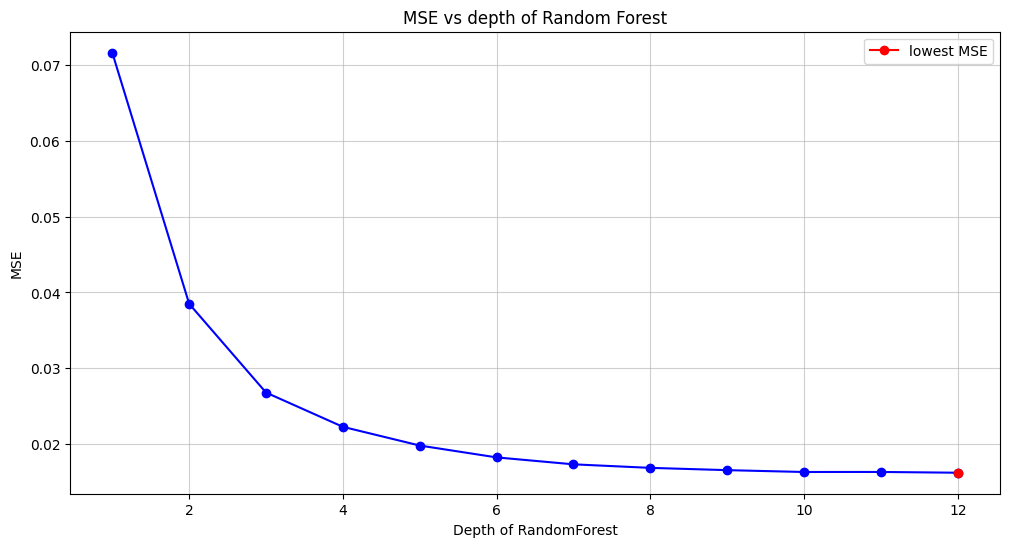

In [ ]:
score_dict = {}
depths = 12
for i in range(1, depths + 1):
    rf = RandomForestRegressor(max_depth = i, random_state = 2025)
    mse = cross_val_mse_score(rf, X, y)
    score_dict[i] = mse
lineplot(score_dict, title_ = 'MSE vs depth of Random Forest', xlab = 'Depth of RandomForest')

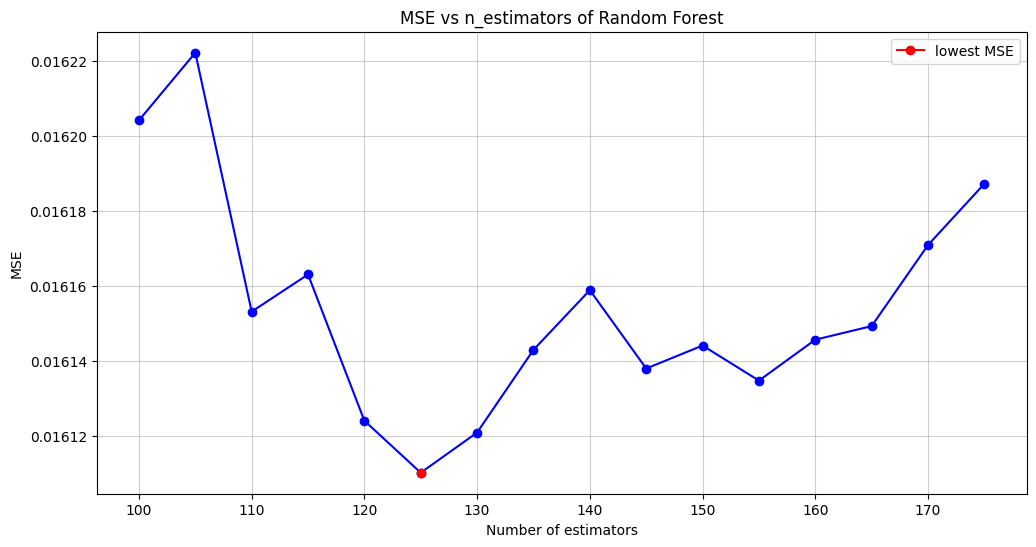

In [24]:
score_dict = {}
n_estimators = 500
early_stoppin = 0
min_mse = float('inf')
for i in range(100, n_estimators + 1, 5):

    rf = RandomForestRegressor(max_depth = 12, n_estimators= i, random_state = 2025)
    mse = cross_val_mse_score(rf, X, y)
    score_dict[i] = mse

    if mse < min_mse:
        min_mse = mse
        early_stoppin = 0
    else:
        early_stoppin += 1

    if early_stoppin == 10:
        break
lineplot(score_dict, title_ = 'MSE vs n_estimators of Random Forest', xlab = 'Number of estimators')

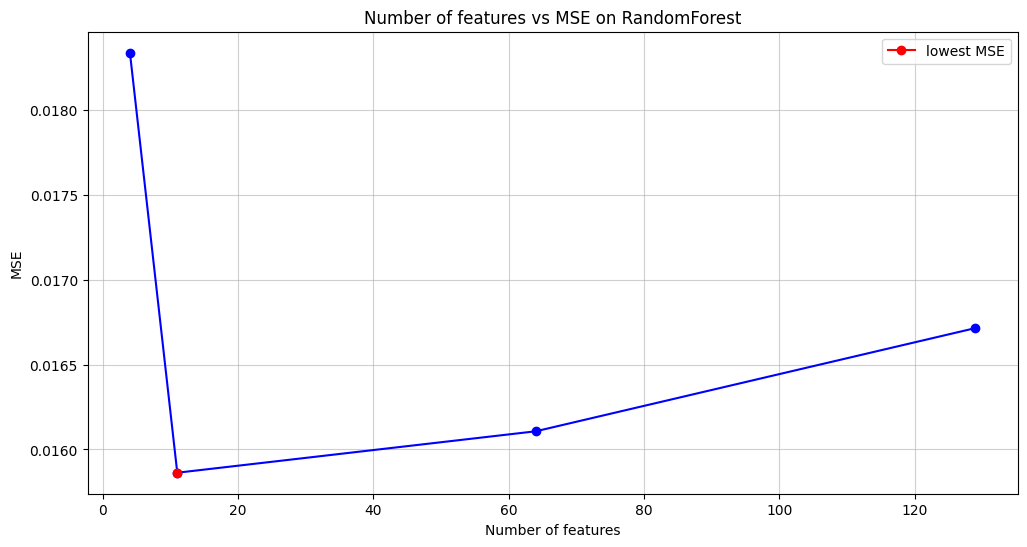

In [25]:
score_dict = {}
max_features_dict = {'log': int(np.log(X.shape[1])),'sqrt': int(np.sqrt(X.shape[1])),'p//2': X.shape[1]//2, 'p': X.shape[1]} #In order

for key, p in max_features_dict.items():
    rf = RandomForestRegressor(max_depth=8, n_estimators=275, max_features = p, random_state = 2025)
    mse = cross_val_mse_score(rf, X, y)
    score_dict[p] = mse
lineplot(score_dict, title_='Number of features vs MSE on RandomForest', xlab='Number of features')

The best score is obtained when P equals sqrt, this means that when the n_estimators are generated, they can only use sqrt(P) random subset of features so the forest in global has different points of view on the predictions giving less correlated answers.

In [28]:
def objective_rf(trial):

    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 350),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 5, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'random_state': 2025,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**param_grid)
    mse = cross_val_mse_score(model, X, y)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=150)
best_params = study.best_params
print("Best hyperparameters:", best_params)
best_rf = RandomForestRegressor(**best_params).fit(X, y)
mse = cross_val_mse_score(best_rf, X, y, info=True)

joblib.dump(best_rf, '..//data//models_trained//best_rf.pkl')
print('Model saved!')

[I 2025-02-28 22:56:03,222] A new study created in memory with name: no-name-d4cd68ff-2b53-4611-82a0-4974c700067d
[I 2025-02-28 22:56:03,876] Trial 0 finished with value: 0.0280587003975007 and parameters: {'n_estimators': 164, 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 61, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.0280587003975007.
[I 2025-02-28 22:56:04,894] Trial 1 finished with value: 0.019614310211148317 and parameters: {'n_estimators': 278, 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 199, 'min_samples_split': 16, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.019614310211148317.
[I 2025-02-28 22:56:05,682] Trial 2 finished with value: 0.021356531931420737 and parameters: {'n_estimators': 222, 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 16, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.019614310211148317.
[I 2025-02-28 22:56:06,670] Trial 3 finished with value: 

Best hyperparameters: {'n_estimators': 322, 'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': 192, 'min_samples_split': 5, 'min_samples_leaf': 1}
The MSE obtained was: 0.015132023256772782
The std obtained was: 0.003832481806749487
Model saved!


# Boosting
The core concept behind boosting models is to create a sequence of models where each new model learns from the errors made by the previous one.

AdaBoost (Adaptive Boosting) is a method that updates the weights of observations with higher errors. This encourages the next model to focus on those harder-to-predict observations in order to improve the overall performance.

Gradient Boosting follows a similar approach, but instead of adjusting weights, it uses the gradient of the loss function to guide the next model. The gradient tells the model the optimal direction to minimize the error, by this improving the models performance by iteratively refining its coefficients.



In [29]:
def objective_ada(trial):
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }
    ada = AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=param_grid['max_depth'], max_features=param_grid['max_features'], random_state=2025),
        n_estimators=param_grid['n_estimators'], learning_rate=param_grid['learning_rate']
    )
    mse = cross_val_mse_score(ada, X, y)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective_ada, n_trials=150)
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')
print(f'CV Score: {study.best_value}')

ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=best_params['max_depth'], max_features=best_params['max_features'], random_state=2025),
    n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate']
)
mse = cross_val_mse_score(ada, X, y, info=True)

best_ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=best_params['max_depth'], max_features=best_params['max_features'], random_state=2025),
    n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate']
).fit(X, y)

joblib.dump(best_ada, '..//data//models_trained//best_ada.pkl')
print('model saved!')

[I 2025-02-28 22:59:21,920] A new study created in memory with name: no-name-0544396e-8b2e-4059-9600-c0fcc5a02b33
[I 2025-02-28 22:59:24,386] Trial 0 finished with value: 0.015925428849991517 and parameters: {'max_depth': 16, 'max_features': 'log2', 'learning_rate': 0.23797364595539522, 'n_estimators': 243}. Best is trial 0 with value: 0.015925428849991517.
[I 2025-02-28 22:59:28,304] Trial 1 finished with value: 0.015920259517860316 and parameters: {'max_depth': 14, 'max_features': 'log2', 'learning_rate': 0.12514071096736679, 'n_estimators': 415}. Best is trial 1 with value: 0.015920259517860316.
[I 2025-02-28 22:59:29,931] Trial 2 finished with value: 0.017756694617403403 and parameters: {'max_depth': 5, 'max_features': 'log2', 'learning_rate': 0.44334051624962373, 'n_estimators': 227}. Best is trial 1 with value: 0.015920259517860316.
[I 2025-02-28 22:59:34,973] Trial 3 finished with value: 0.015379773995367269 and parameters: {'max_depth': 20, 'max_features': 'sqrt', 'learning_rat

Best hyperparameters: {'max_depth': 16, 'max_features': 'sqrt', 'learning_rate': 0.7082701941840128, 'n_estimators': 455}
CV Score: 0.015162176526225254
The MSE obtained was: 0.01542713644289263
The std obtained was: 0.003931327204626093
model saved!


AdaBoost was able to beat the random forest regressor, but the linear models are still winning, what about a Boosting based on gradients?

# GradientBoosting

In [31]:
def objective_gdb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    gdb = GradientBoostingRegressor(**params, random_state=2025)
    mse = cross_val_mse_score(gdb, X, y)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective_gdb, n_trials=125)

best_params = study.best_params
best_score = study.best_value

print(f'Best hyperparameters: {best_params}')
print(f'CV Score: {best_score}')

# Entrenar el mejor modelo con todos los datos
best_gdb = GradientBoostingRegressor(**best_params, random_state=2025)
best_gdb.fit(X, y)
mse = cross_val_mse_score(best_gdb, X, y, info = True)
# Guardar el modelo entrenado
joblib.dump(best_gdb, '..//data//models_trained//best_gdb.pkl')
print('Model saved!')

[I 2025-02-28 23:15:28,530] A new study created in memory with name: no-name-6abba459-c1d2-442c-be87-1aa8a52f0a26
[I 2025-02-28 23:15:36,048] Trial 0 finished with value: 0.013830062978065424 and parameters: {'n_estimators': 667, 'learning_rate': 0.005769825566941899, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.013830062978065424.
[I 2025-02-28 23:15:40,743] Trial 1 finished with value: 0.013180134213201012 and parameters: {'n_estimators': 658, 'learning_rate': 0.045070492616559564, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.013180134213201012.
[I 2025-02-28 23:15:43,595] Trial 2 finished with value: 0.06627847840973312 and parameters: {'n_estimators': 107, 'learning_rate': 0.005199075387867579, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.013180134213201012.
[I 2

Best hyperparameters: {'n_estimators': 978, 'learning_rate': 0.03366859496434412, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}
CV Score: 0.011849758966543151
The MSE obtained was: 0.011849758966543151
The std obtained was: 0.0033242663490371843
Model saved!


# LGBM - CatBoost - XGBoost

In [32]:
def objective_xgb(trial):
    
    n_est = trial.suggest_int('n_estimators', 100, 500)
    lr = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
    md = trial.suggest_int('max_depth', 2, 20)  
    ssample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_by_tree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0.0, 5.0)
    
    xgb_reg = XGBRegressor(
        n_estimators=n_est,
        learning_rate=lr,
        max_depth=md,
        subsample=ssample,
        colsample_bytree=colsample_by_tree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        random_state=2025
    )

    mse = cross_val_mse_score(xgb_reg, X, y)
    return mse

study = optuna.create_study(direction = 'minimize')
study.optimize(objective_xgb, n_trials =250)
best_dt_params = study.best_params
print(f'Best hyperparameters: {best_dt_params}')
print(f'CV Score: {study.best_value}')

best_xgb = XGBRegressor(**study.best_params, random_state = 2025).fit(X, y)
mse = cross_val_mse_score(best_xgb, X, y, info = True)

joblib.dump(best_xgb, '..//data//models_trained//best_xgb.pkl')
print('model saved!')


[I 2025-02-28 23:25:21,118] A new study created in memory with name: no-name-529e09b6-0bab-4f51-9de6-33502a6bd3c6
[I 2025-02-28 23:25:21,997] Trial 0 finished with value: 0.02978852279360844 and parameters: {'n_estimators': 448, 'learning_rate': 0.005802600295100721, 'max_depth': 4, 'subsample': 0.36569335770068045, 'colsample_bytree': 0.4139570798518335, 'min_child_weight': 3, 'gamma': 1.93877705667505}. Best is trial 0 with value: 0.02978852279360844.
[I 2025-02-28 23:25:22,701] Trial 1 finished with value: 0.026290354329107046 and parameters: {'n_estimators': 406, 'learning_rate': 0.008134454258083968, 'max_depth': 15, 'subsample': 0.5482318468783325, 'colsample_bytree': 0.4798083153289807, 'min_child_weight': 6, 'gamma': 2.152415644009291}. Best is trial 1 with value: 0.026290354329107046.
[I 2025-02-28 23:25:23,071] Trial 2 finished with value: 0.03127273908922288 and parameters: {'n_estimators': 107, 'learning_rate': 0.6642847756317708, 'max_depth': 17, 'subsample': 0.84012654249

Best hyperparameters: {'n_estimators': 454, 'learning_rate': 0.028610699940595754, 'max_depth': 18, 'subsample': 0.2546735404264423, 'colsample_bytree': 0.2225347531120902, 'min_child_weight': 10, 'gamma': 0.0019493107779710323}
CV Score: 0.012470765083769245
The MSE obtained was: 0.012470765083769245
The std obtained was: 0.003639654452280961
model saved!


In [33]:
def objective_lgbm(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),  
        'max_depth': trial.suggest_int('max_depth', 2, 12),  
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),  
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),  
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 2025,
        'n_jobs': -1,
        'verbosity': -1  
    }

    model = lgb.LGBMRegressor(objective='regression', metric='mse', **param)
    mse = cross_val_mse_score(model, X, y)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=300)

best_lgbm_params = study.best_params
print(f'Best hyperparameters: {best_lgbm_params}')
print(f'CV Score: {study.best_value}')

best_lgbm = lgb.LGBMRegressor(**study.best_params, objective='regression', random_state=2025).fit(X, y)

joblib.dump(best_lgbm, '..//data//models_trained//best_lgbm.pkl')
print('model saved!')

[I 2025-02-28 23:30:31,339] A new study created in memory with name: no-name-96f77dd3-6d9c-4830-a8b4-b36e0ab891cb
[I 2025-02-28 23:30:33,195] Trial 0 finished with value: 0.017095919704991996 and parameters: {'learning_rate': 0.013547084935135591, 'num_leaves': 164, 'max_depth': 6, 'min_child_samples': 74, 'subsample': 0.8677389057346463, 'colsample_bytree': 0.5492416004524066, 'reg_alpha': 0.015385574877398698, 'reg_lambda': 0.0012475051526233934, 'min_split_gain': 0.21487734957164023, 'extra_trees': False, 'n_estimators': 613}. Best is trial 0 with value: 0.017095919704991996.
[I 2025-02-28 23:30:34,057] Trial 1 finished with value: 0.02203232512165376 and parameters: {'learning_rate': 0.03650362056463703, 'num_leaves': 91, 'max_depth': 2, 'min_child_samples': 57, 'subsample': 0.68785650886499, 'colsample_bytree': 0.5997520173385527, 'reg_alpha': 5.816991394755948, 'reg_lambda': 0.008782137451187624, 'min_split_gain': 0.30598458065124495, 'extra_trees': False, 'n_estimators': 444}. B

Best hyperparameters: {'learning_rate': 0.016770790033027266, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.3846891854727142, 'colsample_bytree': 0.9984821073437326, 'reg_alpha': 0.0006049939287553175, 'reg_lambda': 0.0014166517654591606, 'min_split_gain': 0.0004188906858348014, 'extra_trees': True, 'n_estimators': 920}
CV Score: 0.012307869290730319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7693
[LightGBM] [Info] Number of data points in the train set: 1454, number of used features: 126
[LightGBM] [Info] Start training from score 12.024093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

# Conclusion

Linear models gave better results, but we should take in consideration that we made could made a bigger hyperparameter search but due to lack of computational power we didnt go any deeper which couldve change the outcome.

Now lets do some error analysis in our models predictions.